In [1]:
from konlpy.tag import Mecab
import numpy as np
import pandas as pd
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

tokenizer = Mecab()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']



In [2]:
def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거
    train_data = list(set(train_data))
    test_data = list(set(test_data))
    
    # NaN 결측치 제거
    train_data = [data for data in train_data if str(data) != 'nan']
    test_data = [data for data in test_data if str(data) != 'nan']
    
    # 토큰화 및 불용어 제거
    X_train = [remove_stopwords(tokenizer.morphs(sentence)) for sentence in train_data]
    X_test = [remove_stopwords(tokenizer.morphs(sentence)) for sentence in test_data]
    
    # 단어 집합 생성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    if num_words is None:
        counter = counter.most_common(num_words)
    else:
        counter = counter.items()
    word_to_index = {word: index + 2 for index, (word, _) in enumerate(counter)}
    word_to_index['<PAD>'] = 0  # 패딩을 위한 토큰
    word_to_index['<UNK>'] = 1  # OOV(out-of-vocabulary)를 위한 토큰
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    X_train = [get_encoded_sentence(sentence, word_to_index) for sentence in X_train]
    X_test = [get_encoded_sentence(sentence, word_to_index) for sentence in X_test]
    
    # 레이블 생성
    y_train = np.array([0] * len(X_train))
    y_test = np.array([0] * len(X_test))
    
    # 문장 길이 분포 확인
    total_data = X_train + X_test
    num_tokens = [len(tokens) for tokens in total_data]
    max_len = int(np.percentile(num_tokens, 95))  # 상위 95%의 문장 길이를 최대 문장 길이로 설정
    mean_len = int(np.mean(num_tokens))
    
    # 패딩 추가
    X_train = pad_sequences(X_train, maxlen=max_len, dtype=np.int32, padding='post')
    X_test = pad_sequences(X_test, maxlen=max_len, dtype=np.int32, padding='post')
    
    return X_train, y_train, X_test, y_test, word_to_index, max_len


[2, 2, 2]


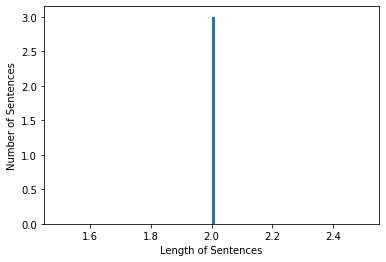

In [3]:
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwords]

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<PAD>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]

def plot_sentence_length_distribution(data):
    num_tokens = [len(tokens) for tokens in data]
    print(num_tokens)
    plt.hist(num_tokens, bins=100)
    plt.xlabel('Length of Sentences')
    plt.ylabel('Number of Sentences')
    plt.show()

# 예시 실행 코드
# train_data와 test_data는 각각 학습 데이터와 테스트 데이터로 구성된 리스트
X_train, y_train, X_test, y_test, word_to_index, max_len = load_data(train_data, test_data, num_words=10000)

# 문장 길이 분포 확인
plot_sentence_length_distribution(X_train)

# 모델 구성 및 validation set 구성
# 모델 훈련 개시
# Loss, Accuracy 그래프 시각화
# 학습된 Embedding 레이어 분석
# 한국어 Word2Vec 임베딩 활용하여 성능 개선


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.6956 - accuracy: 0.5000 - val_loss: 0.6875 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 22ms/step - loss: 0.6847 - accuracy: 1.0000 - val_loss: 0.6801 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 21ms/step - loss: 0.6737 - accuracy: 1.0000 - val_loss: 0.6726 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 21ms/step - loss: 0.6626 - accuracy: 1.0000 - val_loss: 0.6649 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 20ms/step - loss: 0.6513 - accuracy: 1.0000 - val_loss: 0.6570 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 20ms/step - loss: 0.6395 - accuracy: 1.0000 - val_loss: 0.6487 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 20ms/step - loss: 0.6273 - accuracy: 1.0000 - val_loss: 0.6399 - val_accuracy: 1.0000
Epoch 8/10
1/1 [=============

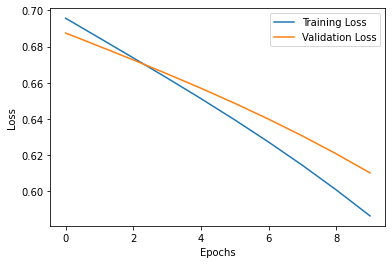

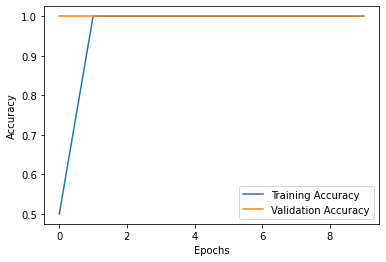

/tmp/ipykernel_284/346084987.py:40: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  word_embeddings = {word: weights[index] for word, index in word_to_index.items() if word in weights}


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Model configuration
embedding_dim = 100
hidden_units = 128

# Model architecture
model = Sequential()
model.add(Embedding(len(word_to_index), embedding_dim, input_length=max_len))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128, callbacks=[early_stopping])

# Loss and Accuracy Visualization
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Analyze the trained Embedding layer
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
word_embeddings = {word: weights[index] for word, index in word_to_index.items() if word in weights}

# Perform analysis or further tasks with the word embeddings
# ...

# Improve performance using pre-trained Korean Word2Vec embeddings
# ...

# Example code ends here
